# Importação

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importando os dados
dataset = pd.read_csv('drug200.csv')
dataset.head()

Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  DrugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  DrugY

# Pré-processamento

In [3]:
# Bibliotecas/funções de pré-processamento
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Realiza OneHotEncoding sobre as variáveis escolhidas
ct_X = ColumnTransformer(transformers=[('Sex:', OneHotEncoder(drop='first'), [1]),
                                    ('Blood Pressure:', OneHotEncoder(drop='first'), [2]),
                                    ('Cholesterol:', OneHotEncoder(drop='first'), [3])], remainder='passthrough')

# A opção drop='first' é utilizada para evitar problemas de alta correlação (posto da matriz de dados)
# entre as variáveis categóricas melhorando a performance dos modelos em geral

# Transforma a variável Drug em numérica para facilitar a utilização da biblioteca PyTorch
ct_y = ColumnTransformer(transformers=[('Drug:', OrdinalEncoder(), [0])], remainder='passthrough')



# Separação da variável de saída (y) e dos preditores (X)
X = dataset.values[:,:-1]
y = dataset.values[:,-1:]

# Aplicando as transformações de codificação das variáveis categóricas
X = ct_X.fit_transform(X)
y = ct_y.fit_transform(y)

# Garantindo que as variáveis são exclusivamente numéricas para evitar problemas nos tipos de dados
X = X.astype(float)
y = y.astype(float)

In [4]:
# Nomeando as variáveis codificadas
columns = [#'Sex: Female',
 'Sex: Male',
#  'Blood Pressure: High',
 'Blood Pressure: Low',
 'Blood Pressure: Normal',
#  'Cholesterol: High',
 'Cholesterol: Normal',
 'Age',
 'Na_to_K']
columns_y = ['Drug: DrugY','Drug: drugA', 'Drug: drugB', 'Drug: drugC', 'Drug: drugX']
columns_dataframe = columns
columns_dataframe.append('Drug')

In [5]:
df = np.concatenate((X,y),axis=1)
df = pd.DataFrame(df,columns=columns_dataframe)
df.to_csv('drug200_preprocessed.csv')

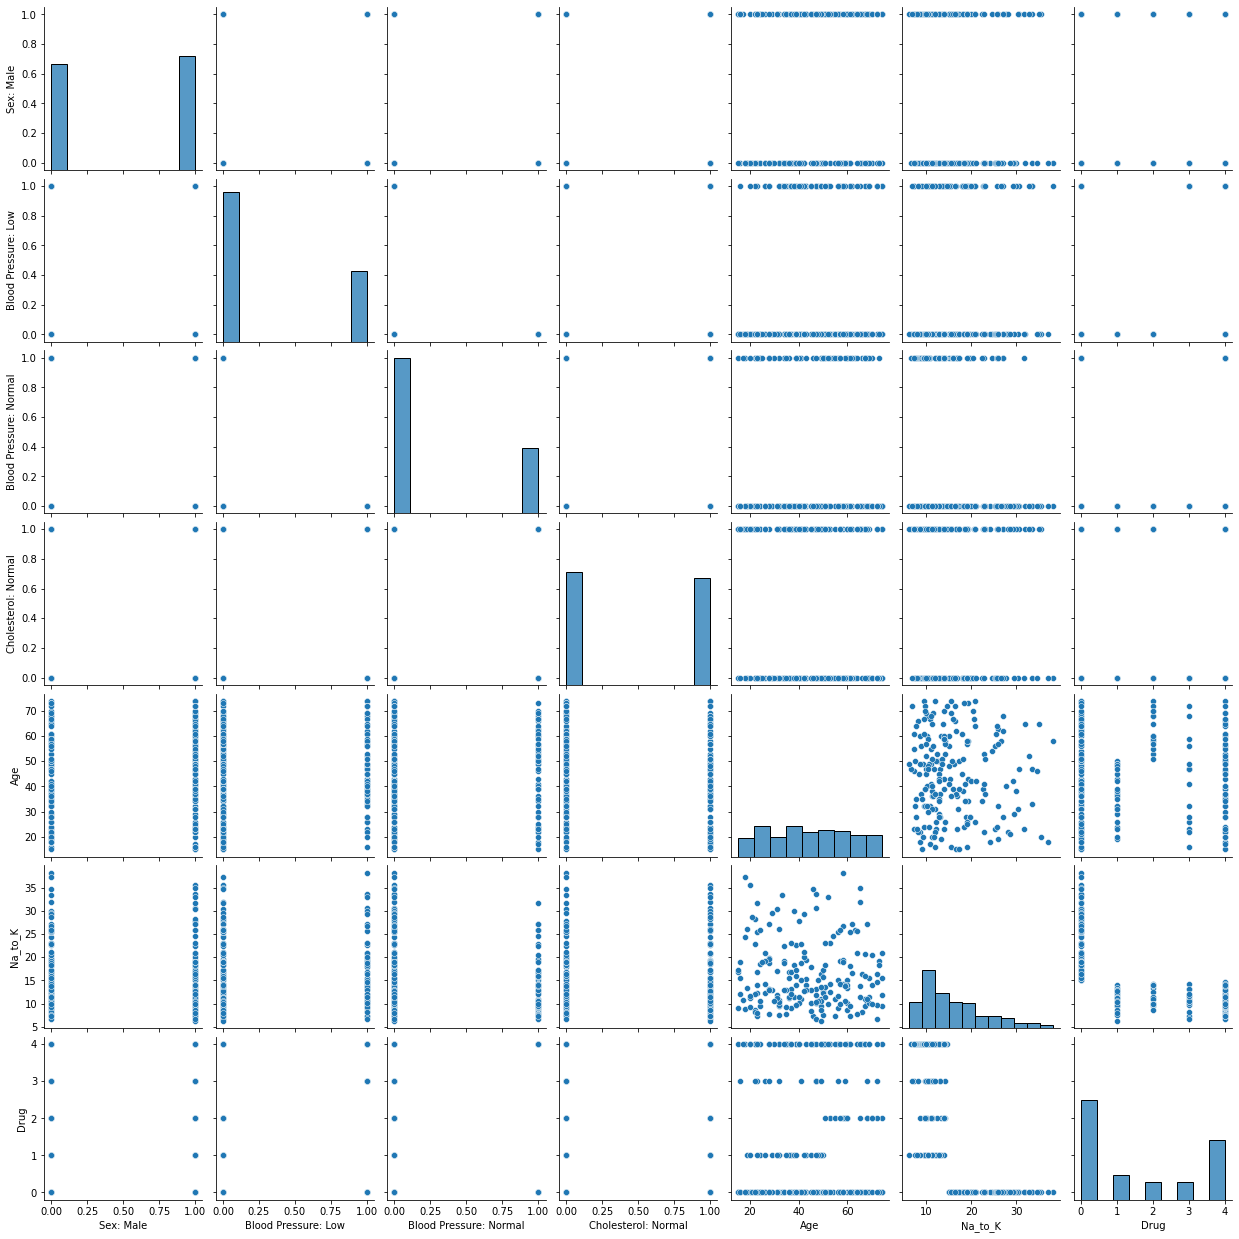

In [6]:
pairplot_dataset = sns.pairplot(df)

plt.show()

In [7]:
figure_pairplot = pairplot_dataset.fig
figure_pairplot.savefig('pairplot_dataset.pdf',dpi=300)

## Conclusões a partir da análise do gráfico

$\bullet$ Vemos que a concentração a razão Na_to_K mais alta que a mediana aparentemente indica que a droga mais provável é a que corresponde à droga Y, que corresponde ao valor 0.

$\bullet$ Em geral, a droga B (valor 2) é utilizada pela população acima dos 50 anos, enquanto que a droga A (valor 1) é utilizada pela população abaixo dos 50. As drogas restantes são bem distribuídas para cada uma das idades.

$\bullet$ Aparentemente a droga C (valor 3) causa um aumento no colesterol, se os pacientes, cujas informações foram coletadas, forem usuários frequentes dessa droga. Lembrando a frase clássica "Correlação não implica causalidade"

$\bullet$ Quanto à pressão, as drogas A e B (valores 1 e 2) parecem ter correlação positiva com a pressão alta. A droga C (valor 3) parece estar correlacionada com a pressão baixa.

In [8]:
# Separação da variável de saída (y) e dos preditores (X)
X = df.values[:,:-1]
y = df.values[:,-1:]

In [9]:
# Embaralhamento dos dados
np.random.seed(42)
m = len(dataset)
train_size = int(0.5*m) # Treino 50% do conjunto
val_size = int(0.25*m) # Validação 25% do conjunto
test_size = m - train_size - val_size # Teste 25% do conjunto
# Índices permutados
idx_perm = list(range(m))
np.random.shuffle(idx_perm)
np.random.seed(None)

# Embaralhamento dos índices
X,y = X[idx_perm],y[idx_perm]
# Separação entre dados de Treino, Validação e Teste
X_train,X_val,X_test = X[:train_size],X[train_size:train_size+val_size],X[train_size+val_size:]
y_train,y_val,y_test = y[:train_size],y[train_size:train_size+val_size],y[train_size+val_size:]

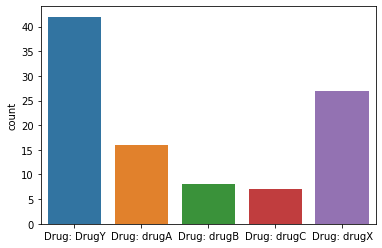

In [10]:
# Verificandos o balanceamento dos dados
sns.countplot(x = y_train[:,0])
plt.xticks(ticks=np.linspace(0,4,5),labels=np.array(columns_y))
plt.show()

In [11]:
# Visto o desbalanceamento entre as classes podemos rebalancear
# para melhorar o desempenho dos modelos
from sklearn.utils import resample

tamanho_1 = sum(y_train == 1)
tamanho_majoritaria = sum(y_train[:,0] == 0)
X_train0 = X_train[y_train[:,0]==0,:]
X_train1 = X_train[y_train[:,0]==1,:]
X_train2 = X_train[y_train[:,0]==2,:]
X_train3 = X_train[y_train[:,0]==3,:]
X_train4 = X_train[y_train[:,0]==4,:]


y_train0 = np.zeros((tamanho_majoritaria,1))


X_train1 = resample(X_train1,
                    replace=True,
                    n_samples=tamanho_majoritaria,
                    random_state=42)
y_train1 = np.ones((tamanho_majoritaria,1))

X_train2 = resample(X_train2,
                    replace=True,
                    n_samples=tamanho_majoritaria,
                    random_state=42)
y_train2 = 2*np.ones((tamanho_majoritaria,1))


X_train3 = resample(X_train3,
                    replace=True,
                    n_samples=tamanho_majoritaria,
                    random_state=42)
y_train3 = 3*np.ones((tamanho_majoritaria,1))

X_train4 = resample(X_train4,
                    replace=True,
                    n_samples=tamanho_majoritaria,
                    random_state=42)
y_train4 = 4*np.ones((tamanho_majoritaria,1))

X_train_modified = np.concatenate([X_train0,X_train1,X_train2,X_train3,X_train4],axis=0)
y_train_modified = np.concatenate([y_train0,y_train1,y_train2,y_train3,y_train4],axis=0)

np.random.seed(42)
l = len(X_train_modified)
idx_shuffling = list(range(l))
np.random.shuffle(idx_shuffling)
np.random.seed(None)

X_train,y_train = X_train_modified[idx_shuffling],y_train_modified[idx_shuffling]

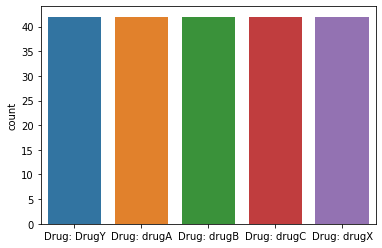

In [12]:
# Verificando o balanceamento dos dados
sns.countplot(x = y_train[:,0])
plt.xticks(ticks=np.linspace(0,4,5),labels=np.array(columns_y))
plt.show()

In [13]:
# Normalizando as variáveis preditoras
sc_X = MinMaxScaler(copy = True)

# Variáveis contidas no intervalo [0,1]
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)
X_test_sc = sc_X.transform(X_test)
X_sc = sc_X.transform(X)

In [14]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms

In [15]:
# Transformando em tensores para a aplicação do PyTorch
X_train_sc_Tensor = transforms.ToTensor()(X_train_sc).squeeze(0)
X_val_sc_Tensor = transforms.ToTensor()(X_val_sc).squeeze(0)
X_test_sc_Tensor = transforms.ToTensor()(X_test_sc).squeeze(0)



y_train_Tensor = transforms.ToTensor()(y_train).squeeze(0).squeeze(1)
y_val_Tensor = transforms.ToTensor()(y_val).squeeze(0).squeeze(1)
y_test_Tensor = transforms.ToTensor()(y_test).squeeze(0).squeeze(1)





# Transformando os tipos para utilização do PyTorch
X_train_sc_Tensor = X_train_sc_Tensor.type(torch.float)
X_val_sc_Tensor = X_val_sc_Tensor.type(torch.float)
X_test_sc_Tensor = X_test_sc_Tensor.type(torch.float)




y_train_Tensor = y_train_Tensor.type(torch.LongTensor)
y_val_Tensor = y_val_Tensor.type(torch.LongTensor)
y_test_Tensor = y_test_Tensor.type(torch.LongTensor)

In [16]:
import numpy as np
import torch
#Implementing EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
#             self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [26]:
# Rede Neural profunda criada no PyTorch para a classificação
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# A rede neural é do tipo feedforward com Batch Normalization 
# entre o neurônio e a função de ativação

# A função de saída é LogSoftmax para poder utilizar a NLLLoss (Negative Log-Likelihood Loss)

# Entrada do modelo é o número de classes, número de neurônios por camada e o tamanho da entrada
class Classification_NN(nn.Module):
    def __init__(self, num_classes=10,num_neurons=10,input_size = 6):
        super(Classification_NN, self).__init__()

        self.layer1 =  nn.Sequential(nn.Linear(input_size,num_neurons),
                        nn.BatchNorm1d(num_neurons),
                        nn.GELU())

        self.layer2 =  nn.Sequential(nn.Linear(num_neurons,num_neurons),
                        nn.BatchNorm1d(num_neurons),
                        nn.GELU())

        self.layer3 =  nn.Sequential(nn.Linear(num_neurons,num_neurons),
                        nn.BatchNorm1d(num_neurons),
                        nn.GELU())

        self.layer4 =  nn.Sequential(nn.Linear(num_neurons,num_neurons),
                        nn.BatchNorm1d(num_neurons),
                        nn.GELU())

        self.layer5 =  nn.Sequential(nn.Linear(num_neurons,num_neurons),
                        nn.BatchNorm1d(num_neurons),
                        nn.GELU())

        self.fc = nn.Sequential(nn.Linear(num_neurons,num_classes),
                        nn.LogSoftmax(dim=1)) 

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.fc(out)
        return out




cpu


In [ ]:
# Hiperparâmetros
num_classes = 5 # Número de classes
num_neurons = 7 #Número de Neurônios por camada escondida
input_size = X_train_sc_Tensor.shape[1] # Tamanho da entrada
learning_rate =  0.8e-4 # Tamanho de passo
num_epochs = 10000 # Número de épocas

# Create the model
model = Classification_NN(num_classes,num_neurons,input_size).to(device)

model.eval() 

train_size_new = X_train_modified.shape[0]

# Loss function
loss_fn = nn.NLLLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=1e-5)


loss_vals = []
running_loss =0.0
# train the model
total_step = len(X_train_sc_Tensor)


list_loss= []
list_time = []
valid_losses = []
avg_valid_losses = []

# Criando o objeto Early stopping
early_stopping = EarlyStopping(patience=6, verbose=False)

# Batch Size por iteração
batch_size =  64

# Contador de Iterações j
j = 0
for epoch in range(num_epochs):
    for i in range(train_size_new//batch_size):
        # Definindo os Batchs
        example = X_train_sc_Tensor[i*batch_size:(i+1)*batch_size] # Preditores
        labels = y_train_Tensor[i*batch_size:(i+1)*batch_size] # Label
        
        # .to(device) move para a unidade de processamento (CPU,GPU,TPU)
        example = example.to(device)
        labels = labels.to(device)
        
        # Aplicando o modelo e utilizando a loss function
        output = model(example)
        loss = loss_fn(output, labels)
        
        # Retornando o gradiente a zero
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Passo do otimizador
        optimizer.step()
        
        # Armazenando o valor da Loss function
        list_loss.append(loss.item())
        list_time.append(j)
        j += 1
        
        model.eval() # prep model for evaluation
        # Utilizando o mesmo processo nos dados de validação
        data = X_val_sc_Tensor # Preditores
        target = y_val_Tensor # Labels
        
        
        data = data.to(device)
        target = target.to(device)
        
        
        output = model(data)
        
        loss = loss_fn(output, target)
        
        # Armazenando a loss function aplicada nos dados de validação
        valid_loss = loss.item()
        avg_valid_losses.append(valid_loss)
        
        # EarlyStopping
        early_stopping(avg_valid_losses[-1], model)
        
        # Mostra as informações periodicamente
        if (j+1) % 128 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, 
                                                                     num_epochs, 
                                                                     j+1, 
                                                                     (train_size_new//batch_size)*num_epochs, 
                                                                     valid_loss))
        
        
        if early_stopping.early_stop:
            break
            
    if early_stopping.early_stop:
            print("Early stopping")
            break

print('Finished Training Trainset')

Epoch [43/10000], Step [128/30000], Loss: 1.6771
Epoch [85/10000], Step [256/30000], Loss: 1.6691
Epoch [128/10000], Step [384/30000], Loss: 1.6611
Epoch [171/10000], Step [512/30000], Loss: 1.6528
Epoch [213/10000], Step [640/30000], Loss: 1.6432
Epoch [256/10000], Step [768/30000], Loss: 1.6289


In [23]:
# Gera o grafo da rede neural
from torchviz import make_dot

make_dot(output, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="pdf")

'rnn_torchviz.pdf'

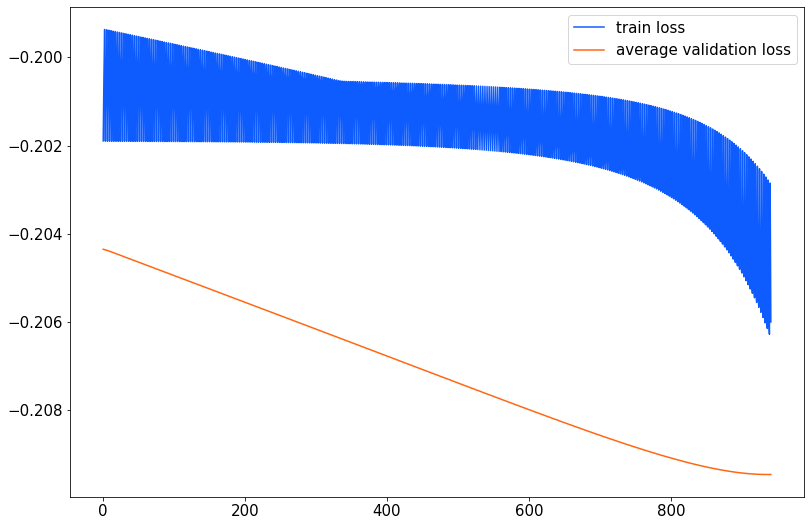

In [24]:
# Verificando se a rede treinou de maneira satisfatória
fig=plt.figure(figsize=(12,8))

ax=fig.add_axes([.1,.1,.85,.85])
x = list(range(len(list_loss)))

ax.plot(x,list_loss,c='#0F5CFE',label='train loss')
ax.plot(x,avg_valid_losses,c='#FF6712',label='average validation loss')
# plt.xticks(ticks=[i*2000 for i in range(6)],labelsize=10)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 15})
plt.show()
fig.savefig('Classification_NN_training_loss.pdf')

In [25]:
# Verificando a performance dos modelos
from sklearn.metrics import classification_report,accuracy_score
output = model(X_test_sc_Tensor)
predict = output.argmax(axis = 1).numpy()
labels = y_test_Tensor.numpy()
print(classification_report(labels,predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.10      1.00      0.18         5
           4       0.00      0.00      0.00        14

    accuracy                           0.10        50
   macro avg       0.02      0.20      0.04        50
weighted avg       0.01      0.10      0.02        50



C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gabriel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1248

In [22]:
# Salva o modelo com melhor performance
# torch.save(model.state_dict(),'./final_model2.pt')

In [23]:
# Importa o modelo com melhor performance
checkpoint = torch.load('final_model2.pt')
model2 = Classification_NN(num_classes,num_neurons)
model2.load_state_dict(checkpoint)
model2.eval()

# Desempenho do modelo com melhor performance
from sklearn.metrics import classification_report,accuracy_score
output = model2(X_test_sc_Tensor)


predict = output.argmax(axis = 1).numpy()
labels = y_test_Tensor.numpy()
print('Performance Treino')
print(classification_report(labels,predict))


dict_classification_report = classification_report(labels,predict,output_dict=True)
class_report = pd.DataFrame(dict_classification_report)
class_report = class_report.T
class_report.to_latex('as.tex',encoding='utf-8')


# Verificando o desempenho nos dados de validação

output_train = model2(X_val_sc_Tensor)



predict = output_train.argmax(axis = 1).numpy()
labels = y_val_Tensor.numpy()
print('Performance Treino')
print(classification_report(labels,predict))

Performance Treino
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00        14

    accuracy                           0.96        50
   macro avg       0.90      0.99      0.93        50
weighted avg       0.97      0.96      0.96        50

Performance Treino
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        22
           1       0.80      0.80      0.80         5
           2       0.83      0.83      0.83         6
           3       0.67      1.00      0.80         4
           4       0.92      0.92      0.92        13

    accuracy                           0.88        50
   macro avg       0.83      0.88      0.85        50
weighted avg       0.89      0.88      

In [24]:
import shap

# Função para predizer a probabilidade de cada uma das classes
def predict(x):
    y = transforms.ToTensor()(x).squeeze(0).type(torch.float)
    with torch.no_grad():
        output = model2(y)
        return output.numpy()


# Variáveis selecionadas
features = columns
explainer = shap.KernelExplainer(predict, X_sc)
# Gerando os shap values para verificar os impactos da variáveis sobre as variáveis 
shap_values = explainer.shap_values(X_sc)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

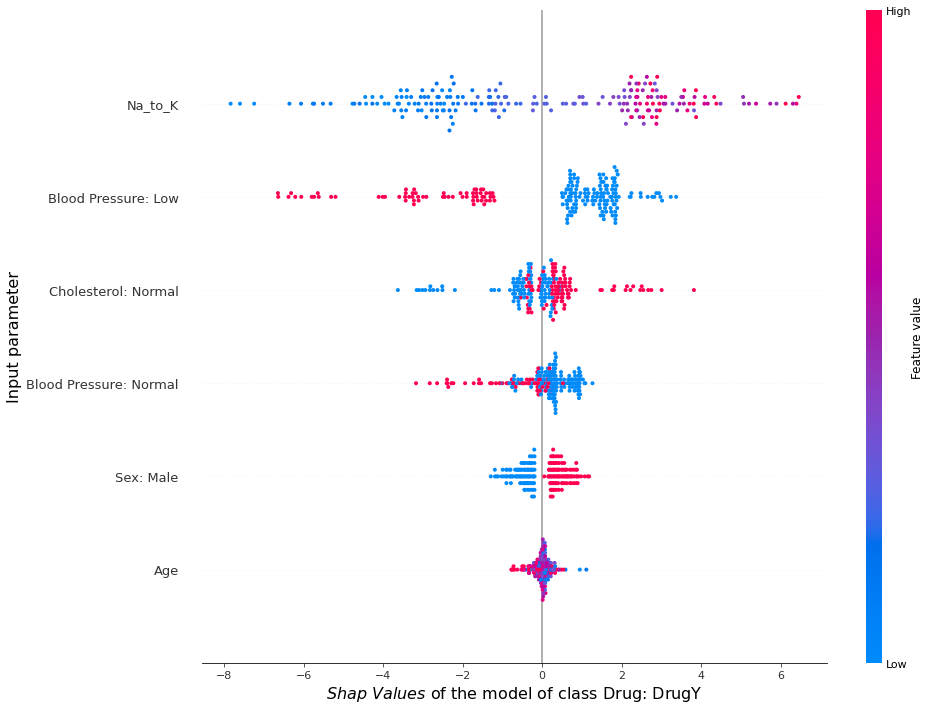

In [25]:

shap.initjs()
k = 0
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)
plt.show()

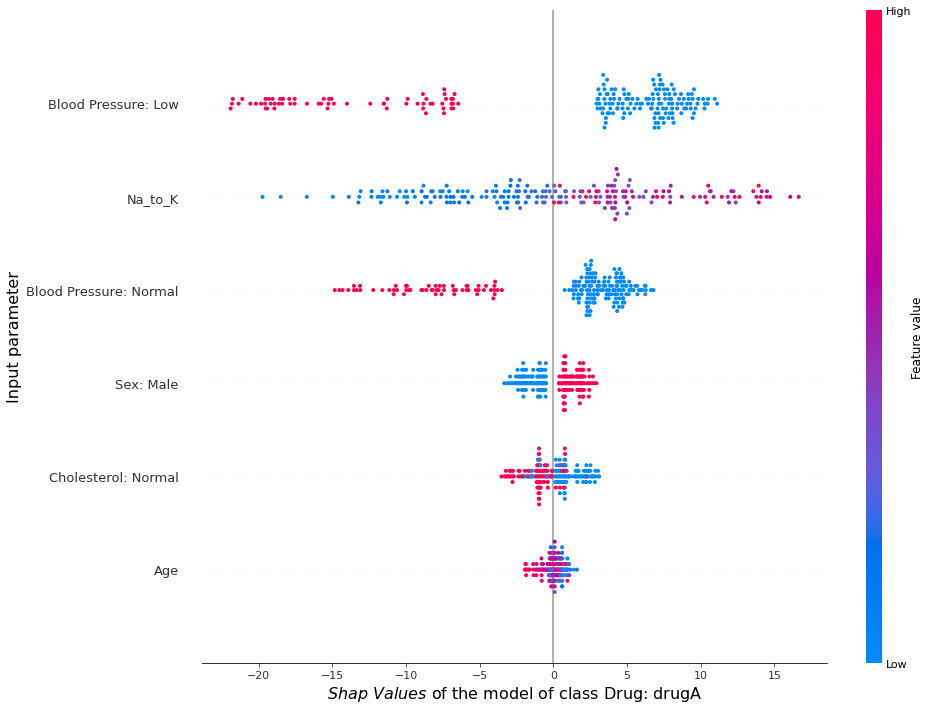

In [26]:

shap.initjs()
k = 1
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)
plt.show()

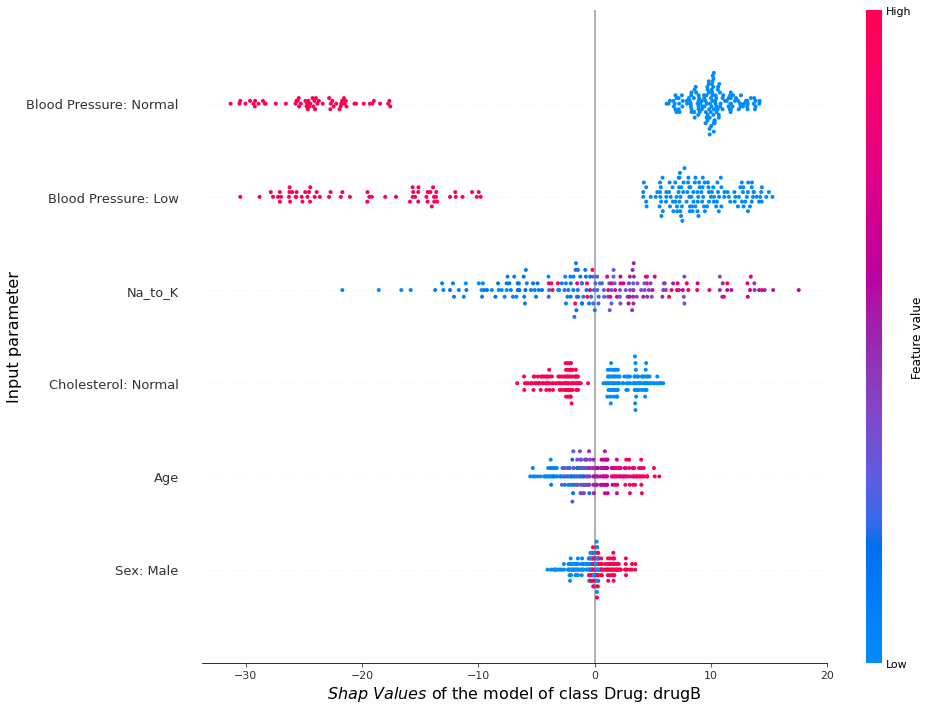

In [27]:

shap.initjs()
k = 2
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)
plt.show()

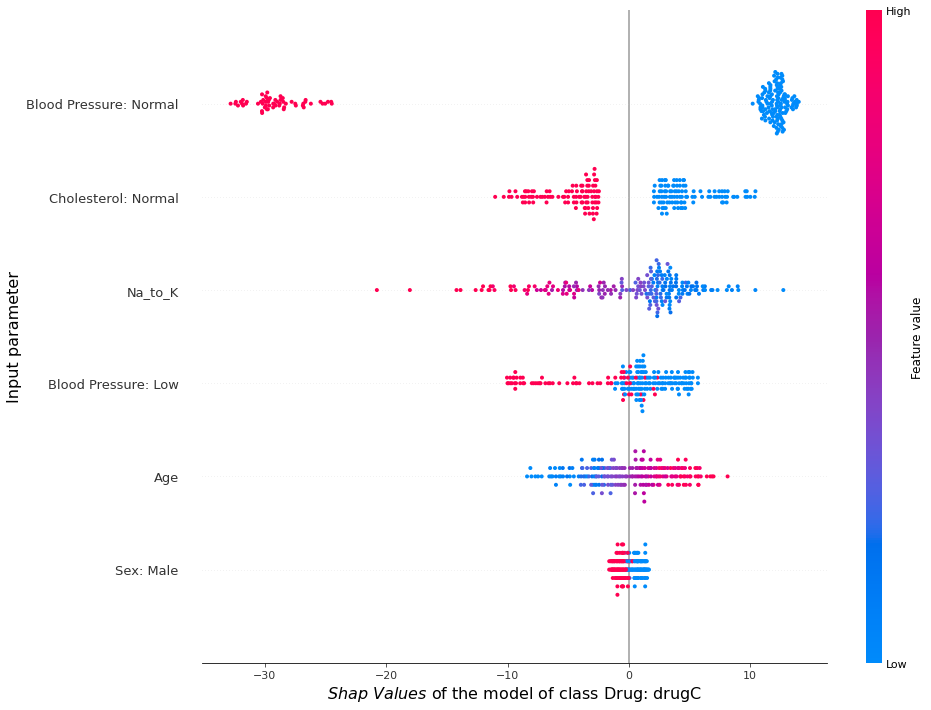

In [28]:

shap.initjs()
k = 3
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)
plt.show()

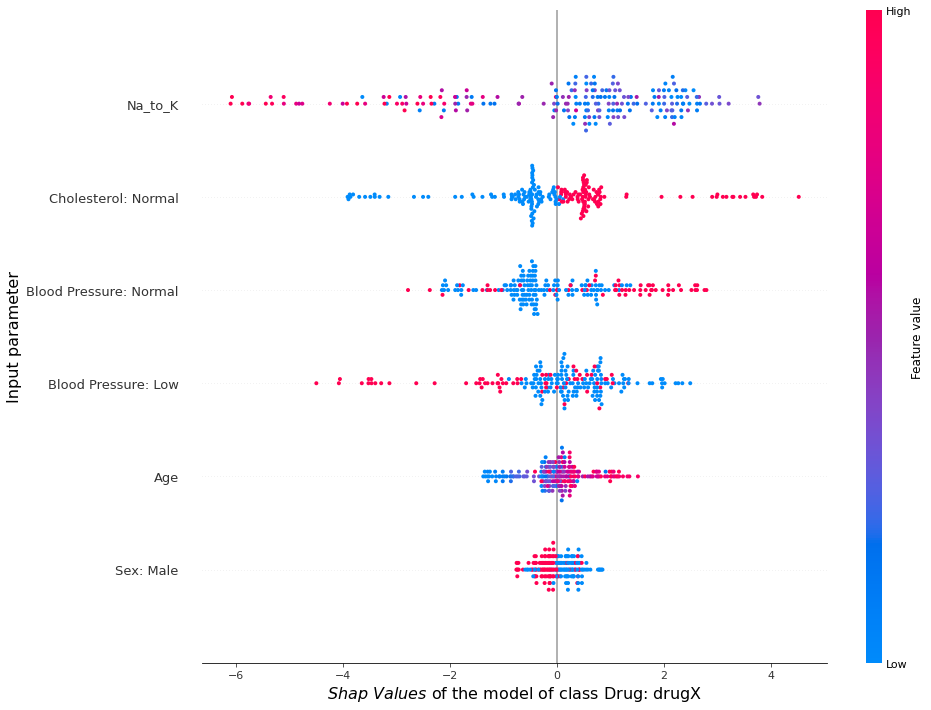

In [29]:

shap.initjs()
k = 4
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(14)
ax = plt.gca()
ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

splitter = ['best','random']
max_depth = list(range(1,40))
distribution = dict(max_depth = max_depth)
classifier = RandomForestClassifier(random_state=42,criterion='gini')
rscv = RandomizedSearchCV(classifier,random_state=42,param_distributions=distribution,n_iter=20)


X_train_sc_new = np.concatenate((X_train_sc,X_val_sc),axis=0)
y_train_new = np.concatenate((y_train,y_val),axis=0)

rscv.fit(X_train_sc_new,y_train_new[:,0])
best_classifier = rscv.best_estimator_
best_params = rscv.best_params_
best_score = rscv.best_score_


#####################################################
print(best_params)
print(best_score)

{'max_depth': 34}
0.9961538461538462


In [31]:
from sklearn.metrics import classification_report
y_val_pred = best_classifier.predict(X_val_sc)
y_test_pred = best_classifier.predict(X_test_sc)


print(classification_report(y_test,y_test_pred))


dict_classification_report = classification_report(y_test,y_test_pred,output_dict=True)
class_report = pd.DataFrame(dict_classification_report)
class_report = class_report.T
class_report.to_latex('as.tex',encoding='utf-8')

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        27
         1.0       1.00      1.00      1.00         2
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         5
         4.0       1.00      1.00      1.00        14

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [32]:
import shap

explainer = shap.TreeExplainer(best_classifier)
shap_values = explainer.shap_values(X_sc)

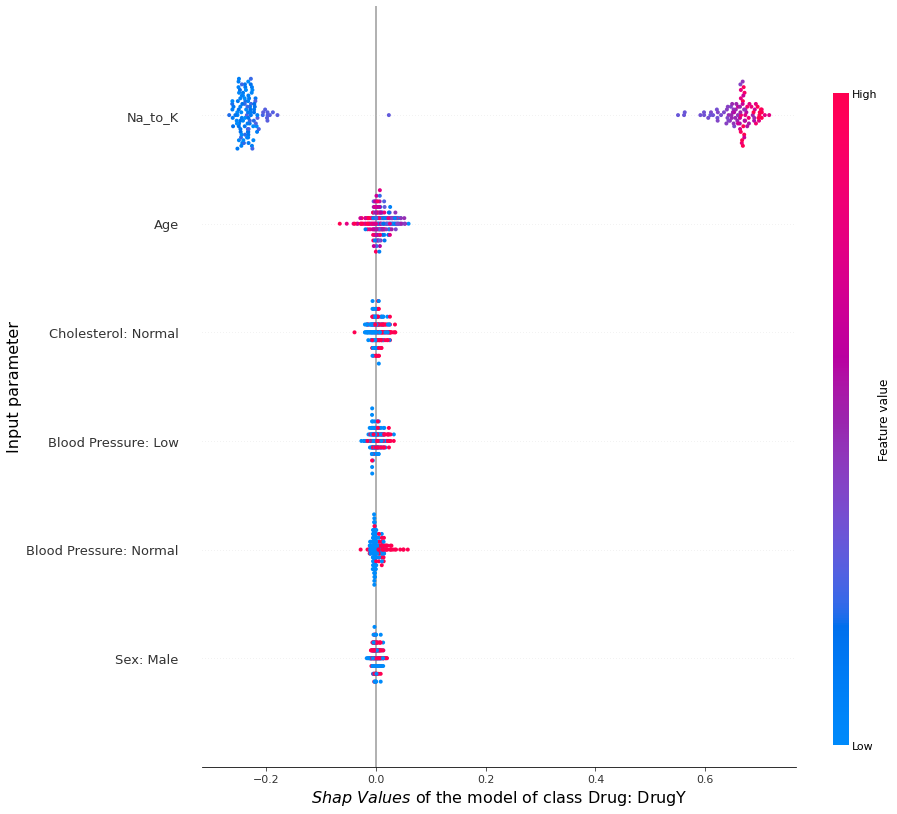

In [33]:

shap.initjs()
k = 0
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(15)
ax = plt.gca()
ax.set_position((.2,.1,0.55,0.88))

ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)

fig.savefig('shap_drug' + columns_y[k][-1] + '.pdf')
plt.show()

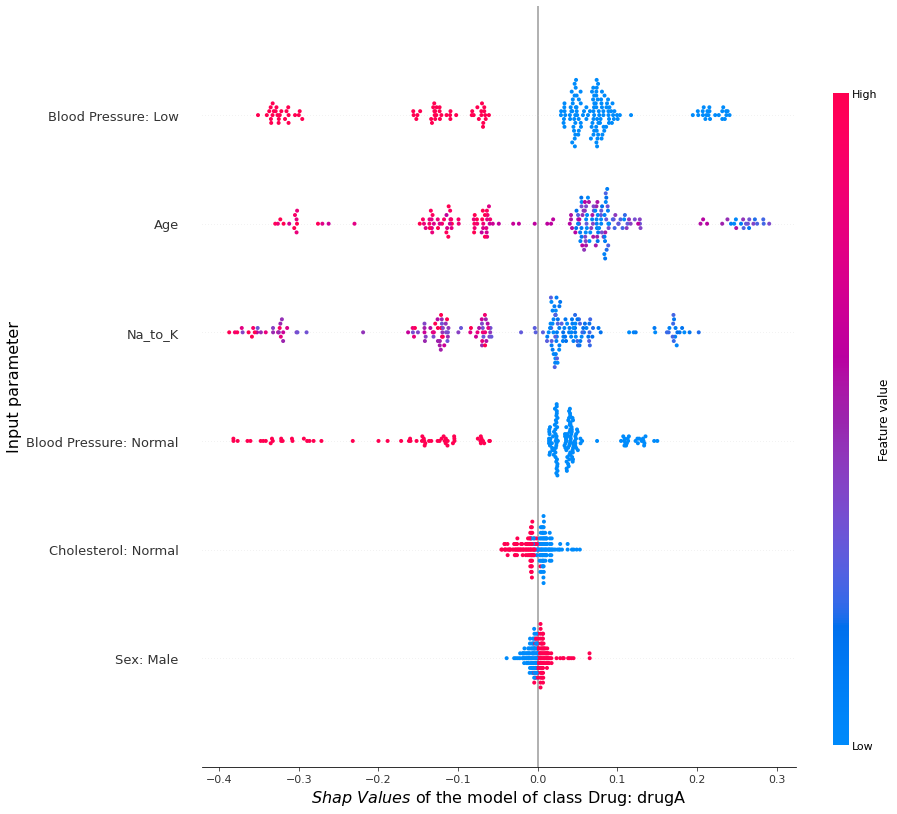

In [34]:

shap.initjs()
k = 1
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(15)
ax = plt.gca()
ax.set_position((.2,.1,0.55,0.88))

ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)

fig.savefig('shap_drug' + columns_y[k][-1] + '.pdf')
plt.show()

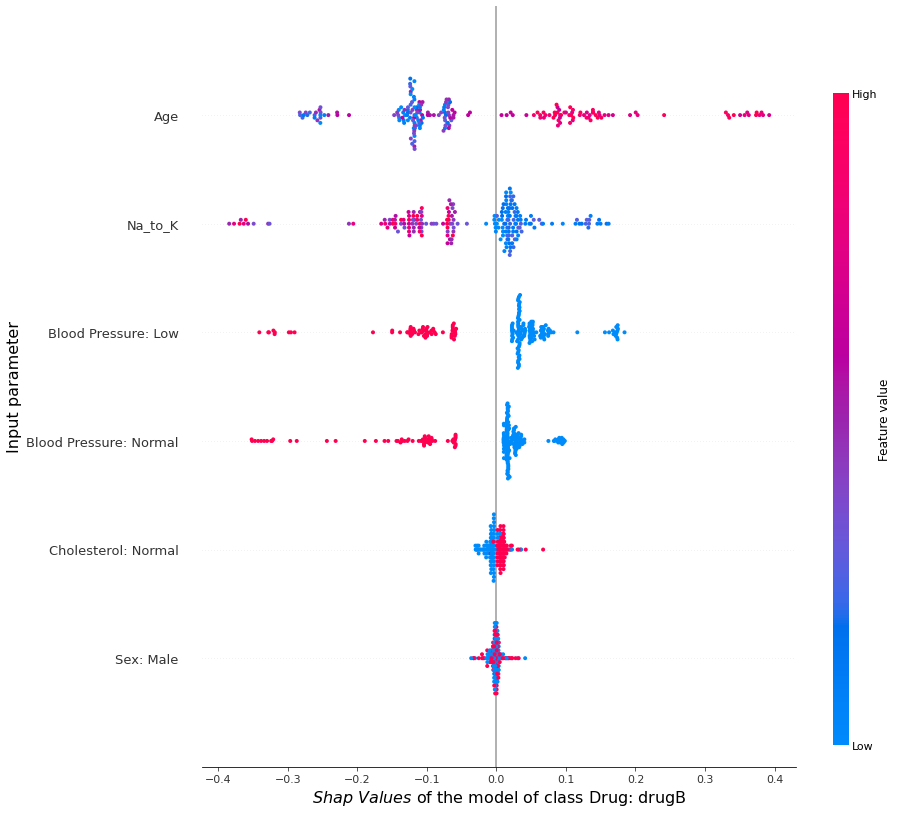

In [35]:

shap.initjs()
k = 2
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(15)
ax = plt.gca()
ax.set_position((.2,.1,0.55,0.88))

ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)

fig.savefig('shap_drug' + columns_y[k][-1] + '.pdf')
plt.show()

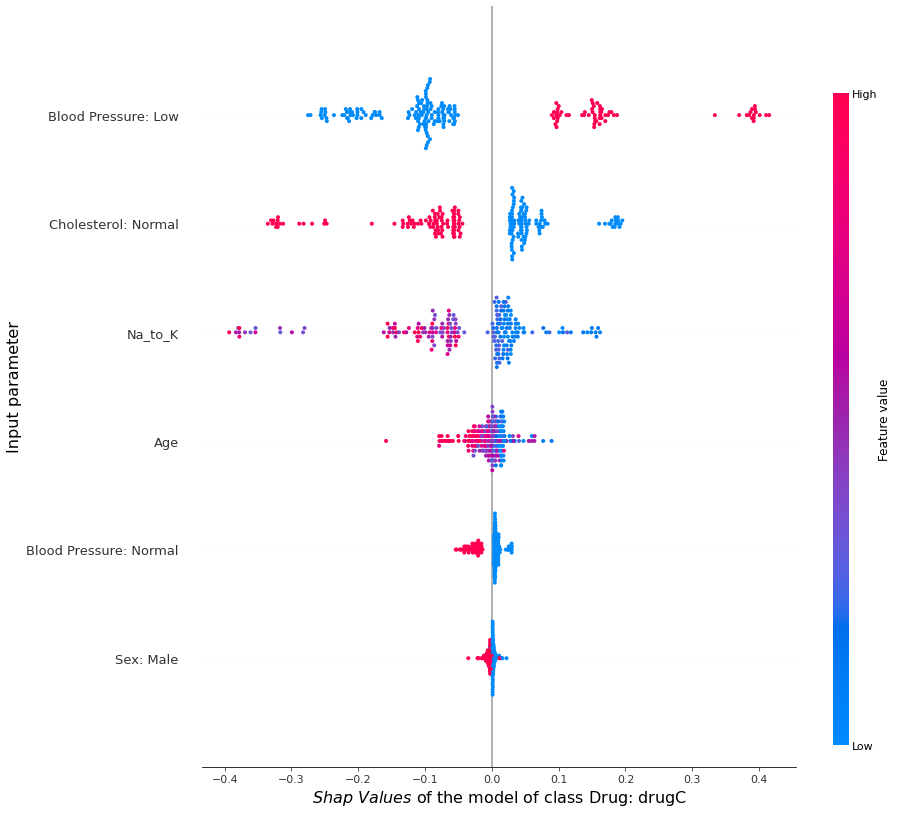

In [36]:

shap.initjs()
k = 3
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(15)
ax = plt.gca()
ax.set_position((.2,.1,0.55,0.88))

ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)

fig.savefig('shap_drug' + columns_y[k][-1] + '.pdf')
plt.show()

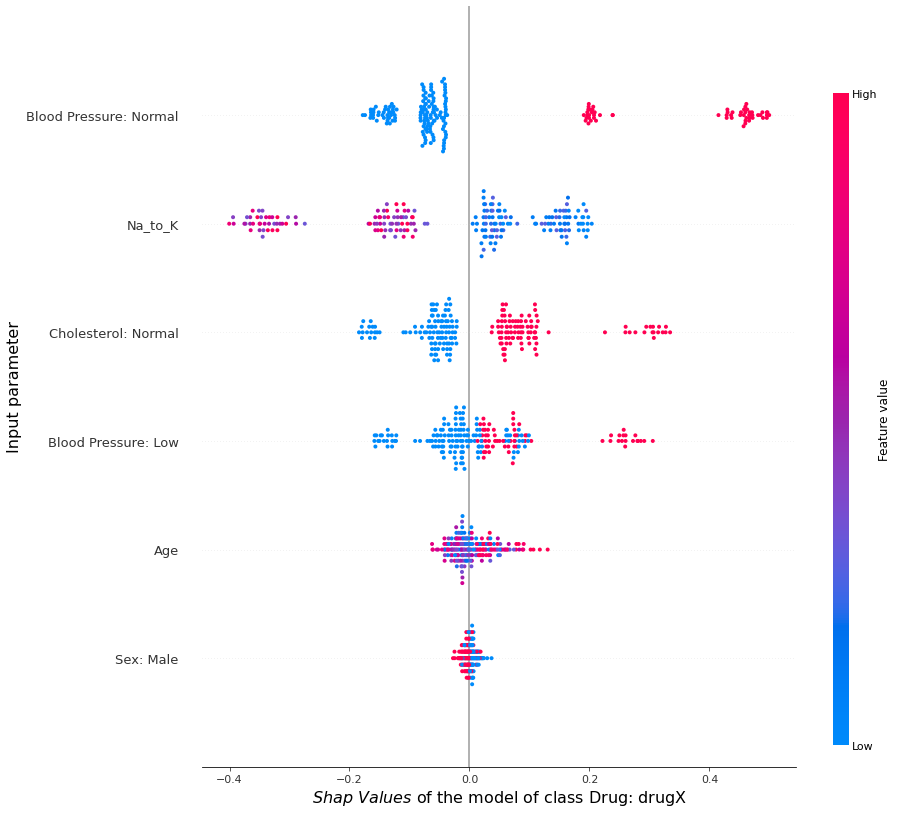

In [37]:

shap.initjs()
k = 4
shap.summary_plot(shap_values[k],X_sc,feature_names=features,show=False)
perm = [3,4,1,2,0]
fig = plt.gcf()
fig.set_figheight(12)
fig.set_figwidth(15)
ax = plt.gca()
ax.set_position((.2,.1,0.55,0.88))

ax.set_xlabel('$Shap\ Values$ of the model of class ' + columns_y[k], fontsize=16)
ax.set_ylabel('Input parameter', fontsize=16)
ylabels = ([tick.get_text() for tick in ax.get_yticklabels()])
ax.set_yticklabels(ylabels)

fig.savefig('shap_drug' + columns_y[k][-1] + '.pdf')
plt.show()